In [1]:
import pandas as pd

df = pd.read_csv('StudentPerformanceFactors.csv')

In [2]:
col_nulas = ['Parental_Education_Level', 'Teacher_Quality', 'Distance_from_Home']

for col in col_nulas:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

df.isnull().sum()[col_nulas]

Parental_Education_Level    0
Teacher_Quality             0
Distance_from_Home          0
dtype: int64

In [3]:
from sklearn.preprocessing import LabelEncoder

cols_cats = df.select_dtypes(include='object').columns

encoders = {}

for col in cols_cats:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [4]:
categorical_candidates = [
    'Gender',
    'School_Type',
    'Parental_Education_Level',
    'Internet_Access',
    'Access_to_Resources',
    'Parental_Involvement',
    'Learning_Disabilities'
]

categorical_features = []
for col in categorical_candidates:
    if col in df.columns:
        categorical_features.append(col)

numeric_features = [col for col in df.columns
                    if col not in categorical_features and col != 'Exam_Score']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Formato do X_train transformado:', X_train_transformed.shape)
print('Formato do X_test transformado:', X_test_transformed.shape)

Formato do X_train transformado: (5285, 29)
Formato do X_test transformado: (1322, 29)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lin_model = LinearRegression()
lin_model.fit(X_train_transformed, y_train)

lin_preds = lin_model.predict(X_test_transformed)

lin_r2 = r2_score(y_test, lin_preds)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))

print('R²:', lin_r2)
print('MAE:', lin_mae)
print('RMSE:', lin_rmse)

R²: 0.7461662630177788
MAE: 0.655894469864475
RMSE: 1.8941906631462084


In [7]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf_model.fit(X_train_transformed, y_train)

rf_preds = rf_model.predict(X_test_transformed)

rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print('R²:', rf_r2)
print('MAE:', rf_mae)
print('RMSE:', rf_rmse)

R²: 0.6717787410420308
MAE: 1.0728542612203729
RMSE: 2.1539339085887708


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

print('Melhores parâmetros:', grid_search.best_params_)
print('Melhor R² no treino (CV):', grid_search.best_score_, '\n')

best_rf = grid_search.best_estimator_

rf_preds_gs = best_rf.predict(X_test_transformed)

print('R²:', r2_score(y_test, rf_preds_gs))
print('MAE:', mean_absolute_error(y_test, rf_preds_gs))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_preds_gs)))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Melhor R² no treino (CV): 0.6335670964437835 

R²: 0.6872710915370595
MAE: 1.0504075850752743
RMSE: 2.102485620769685


In [9]:
importances = best_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

rf_importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
)

rf_importances.head(15)

,feature,importance
1,num__Attendance,0.445067
0,num__Hours_Studied,0.266552
4,num__Previous_Scores,0.074134
6,num__Tutoring_Sessions,0.031042
21,cat__Access_to_Resources_0,0.022197
24,cat__Parental_Involvement_0,0.021762
3,num__Sleep_Hours,0.014582
10,num__Physical_Activity,0.013150
9,num__Peer_Influence,0.012196
7,num__Family_Income,0.011797


In [10]:
from sklearn.linear_model import LinearRegression

X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

model_lr = LinearRegression()
model_lr.fit(X_train_encoded, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
lin_coefs = model_lr.coef_
feature_names = preprocessor.get_feature_names_out()

lin_importances = (
    pd.DataFrame({
        'feature': feature_names,
        'coef': lin_coefs
    })
    .assign(abs_coef=lambda df: df['coef'].abs())
    .sort_values('abs_coef', ascending=False)
)

lin_importances.head(15)

,feature,coef,abs_coef
1,num__Attendance,2.283051,2.283051
0,num__Hours_Studied,1.750732,1.750732
22,cat__Access_to_Resources_1,-1.055508,1.055508
24,cat__Parental_Involvement_0,1.030140,1.030140
21,cat__Access_to_Resources_0,1.029646,1.029646
25,cat__Parental_Involvement_1,-0.987896,0.987896
4,num__Previous_Scores,0.692457,0.692457
6,num__Tutoring_Sessions,0.625408,0.625408
18,cat__Parental_Education_Level_2,0.501104,0.501104
20,cat__Internet_Access_1,0.493641,0.493641


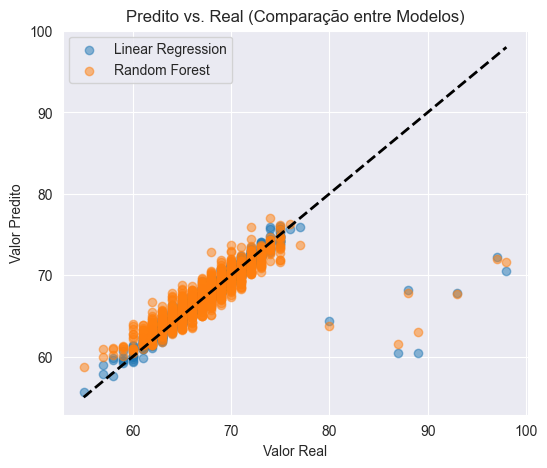

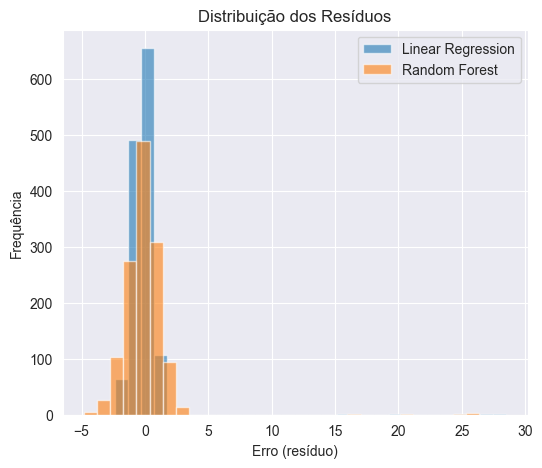

In [12]:
import matplotlib.pyplot as plt

y_pred_lr = model_lr.predict(X_test_encoded)
y_pred_rf = best_rf.predict(X_test_encoded)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Predito vs. Real (Comparação entre Modelos)')
plt.legend()
plt.show()

res_lr = y_test - y_pred_lr
res_rf = y_test - y_pred_rf

plt.figure(figsize=(6, 5))
plt.hist(res_lr, bins=30, alpha=0.6, label='Linear Regression')
plt.hist(res_rf, bins=30, alpha=0.6, label='Random Forest')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Erro (resíduo)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

final_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

preds_final = final_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_final))

print('R²:', r2_score(y_test, preds_final))
print('RMSE:', rmse)

R²: 0.9529269899577553
RMSE: 0.815708531567503
